In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Reshape, BatchNormalization, Dropout, SimpleRNN, GRU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import pickle

In [2]:
#Defining hyperparameters
# Hyperparameters
learning_rate = 0.00025
epochs = 50
batch_size = 32
dropout_rate = 0.15

# CNN Hyperparameters
cnn_filters = [64, 128, 256]
cnn_kernel_size = 5
cnn_pool_size = 3

# LSTM Hyperparameters
lstm_units = [100, 150]

# RNN Hyperparameters
rnn_units = [100, 150]

# GRU Hyperparameters
gru_units = [100, 150]

In [7]:
pm25_excel_file

'Datasets.xlsx'

In [9]:
df['PM25_prev']

Date
1980-01-02    12.228019
1980-01-03    12.047198
1980-01-04    10.525182
1980-01-05    10.105839
1980-01-06    10.118784
                ...    
2023-12-27    55.034569
2023-12-28    56.725060
2023-12-29    62.890263
2023-12-30    68.137840
2023-12-31    73.697243
Name: PM25_prev, Length: 16070, dtype: float64

In [3]:
#Loding and Preparing the Datasets
# Path to your Excel file
pm25_excel_file = 'Datasets.xlsx'

# Load PM2.5 data
sheet_name = pd.ExcelFile(pm25_excel_file).sheet_names[0]
df = pd.read_excel(pm25_excel_file, sheet_name=sheet_name)

# Ensure 'Date' is a datetime column and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Drop any rows with missing values
df.dropna(inplace=True)

# Add previous day's PM2.5 and other lagged features
df['PM25_prev'] = df['PM25'].shift(1)
df['P_prev'] = df['P'].shift(1)
df['Tmin_prev'] = df['Tmin'].shift(1)
df['Tmax_prev'] = df['Tmax'].shift(1)
df['w_prev'] = df['w'].shift(1)

# Drop any rows with missing values after adding lagged features
df.dropna(inplace=True)

# Check and handle non-numeric data
df = df.apply(pd.to_numeric, errors='coerce')
df.dropna(inplace=True)

In [15]:
def split_by_random_years(df, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    # Convert Index to a NumPy array
    years = np.array(df.index.year.unique())  # Ensure it's a NumPy array
    
    # Shuffle the years
    np.random.shuffle(years)
    
    # Split the years into training, validation, and test sets
    total_years = len(years)
    train_years = years[:int(total_years * train_ratio)]
    val_years = years[int(total_years * train_ratio):int(total_years * (train_ratio + val_ratio))]
    test_years = years[int(total_years * (train_ratio + val_ratio)):]

    # Create dataframes for each set based on the years
    train_df = df[df.index.year.isin(train_years)]
    val_df = df[df.index.year.isin(val_years)]
    test_df = df[df.index.year.isin(test_years)]

    return train_df, val_df, test_df

# Split the data
train_df, val_df, test_df = split_by_random_years(df)

In [13]:
# Define features and target
features_columns = ['PM25_prev', 'P', 'P_prev', 'Tmin', 'Tmin_prev', 'Tmax', 'Tmax_prev', 'w', 'w_prev']

def prepare_data(df):
    features = df[features_columns]
    target = df['PM25']
    X = features.values
    y = target.values
    return X, y

X_train, y_train = prepare_data(train_df)
X_val, y_val = prepare_data(val_df)
X_test, y_test = prepare_data(test_df)
X , y =prepare_data(df)
# Normalize features
scaler_X = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

# Normalize target
scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_val = scaler_y.transform(y_val.reshape(-1, 1))
y_test = scaler_y.transform(y_test.reshape(-1, 1))

# Reshape for model input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [16]:
# Normalize features
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Normalize target
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

In [17]:
# Split the data into train, validation, and test sets using 70:20:10 ratio
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42, shuffle=False)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")

Train shape: (11249, 9), Validation shape: (3230, 9), Test shape: (1591, 9)


In [18]:
#Defining CNN-LSTM
def build_cnn_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    
    x = Conv1D(filters=cnn_filters[0], kernel_size=cnn_kernel_size, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=cnn_pool_size, padding='same')(x)
    
    x = Conv1D(filters=cnn_filters[1], kernel_size=cnn_kernel_size, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=cnn_pool_size, padding='same')(x)
    
    x = Conv1D(filters=cnn_filters[2], kernel_size=cnn_kernel_size, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    
    x = LSTM(lstm_units[0], return_sequences=True)(x)
    x = LSTM(lstm_units[1], return_sequences=False)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1)(x)
    
    model = Model(inputs, outputs)
    return model

In [19]:
# Defining CNN-RNN
def build_cnn_rnn_model(input_shape):
    inputs = Input(shape=input_shape)
    
    x = Conv1D(filters=cnn_filters[0], kernel_size=cnn_kernel_size, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=cnn_pool_size, padding='same')(x)
    
    x = Conv1D(filters=cnn_filters[1], kernel_size=cnn_kernel_size, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=cnn_pool_size, padding='same')(x)
    
    x = Conv1D(filters=cnn_filters[2], kernel_size=cnn_kernel_size, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    
    x = SimpleRNN(rnn_units[0], return_sequences=True)(x)
    x = SimpleRNN(rnn_units[1], return_sequences=False)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1)(x)
    
    model = Model(inputs, outputs)
    return model

In [20]:
#Defining CNN-GRU
def build_cnn_gru_model(input_shape):
    inputs = Input(shape=input_shape)
    
    x = Conv1D(filters=cnn_filters[0], kernel_size=cnn_kernel_size, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=cnn_pool_size, padding='same')(x)
    
    x = Conv1D(filters=cnn_filters[1], kernel_size=cnn_kernel_size, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=cnn_pool_size, padding='same')(x)
    
    x = Conv1D(filters=cnn_filters[2], kernel_size=cnn_kernel_size, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    
    x = GRU(gru_units[0], return_sequences=True)(x)
    x = GRU(gru_units[1], return_sequences=False)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1)(x)
    
    model = Model(inputs, outputs)
    return model

In [21]:
# Initialize models with 2D input shape
input_shape = (X_train.shape[1], 1)  # X_train.shape[1] corresponds to the number of features

cnn_lstm_model = build_cnn_lstm_model(input_shape)
cnn_rnn_model = build_cnn_rnn_model(input_shape)
cnn_gru_model = build_cnn_gru_model(input_shape)

# Compile models
cnn_lstm_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
cnn_rnn_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
cnn_gru_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

checkpoint_cnn_lstm = ModelCheckpoint('best_cnn_lstm_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
checkpoint_cnn_rnn = ModelCheckpoint('best_cnn_rnn_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
checkpoint_cnn_gru = ModelCheckpoint('best_cnn_gru_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Reshape the data to fit the models' input
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Train models
cnn_lstm_history = cnn_lstm_model.fit(X_train_reshaped, y_train, epochs=epochs, batch_size=batch_size, 
                                      validation_data=(X_val_reshaped, y_val), 
                                      callbacks=[early_stopping, lr_reducer, checkpoint_cnn_lstm])

cnn_rnn_history = cnn_rnn_model.fit(X_train_reshaped, y_train, epochs=epochs, batch_size=batch_size, 
                                    validation_data=(X_val_reshaped, y_val), 
                                    callbacks=[early_stopping, lr_reducer, checkpoint_cnn_rnn])

cnn_gru_history = cnn_gru_model.fit(X_train_reshaped, y_train, epochs=epochs, batch_size=batch_size, 
                                    validation_data=(X_val_reshaped, y_val), 
                                    callbacks=[early_stopping, lr_reducer, checkpoint_cnn_gru])

Epoch 1/50
349/352 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027
Epoch 1: val_loss improved from inf to 0.00547, saving model to best_cnn_lstm_model.keras
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0027 - val_loss: 0.0055 - learning_rate: 2.5000e-04
Epoch 2/50
344/352 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016
Epoch 2: val_loss improved from 0.00547 to 0.00376, saving model to best_cnn_lstm_model.keras
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0016 - val_loss: 0.0038 - learning_rate: 2.5000e-04
Epoch 3/50
349/352 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020
Epoch 3: val_loss improved from 0.00376 to 0.00373, saving model to best_cnn_lstm_model.keras
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0020 - val_loss: 0.0037 - learning_rate: 2.5000e-04
Epoch 4/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015
Epoch 4: val_loss improved from 0.00373 to 0.00355, saving model to best_cnn_lstm_model.keras
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.

In [22]:
#Load the Best Models and Make Predictions
# Load the best models
best_cnn_lstm_model = load_model('best_cnn_lstm_model.keras')
best_cnn_rnn_model = load_model('best_cnn_rnn_model.keras')
best_cnn_gru_model = load_model('best_cnn_gru_model.keras')

# Make predictions on the test set
cnn_lstm_pred = best_cnn_lstm_model.predict(X_test_reshaped)
cnn_rnn_pred = best_cnn_rnn_model.predict(X_test_reshaped)
cnn_gru_pred = best_cnn_gru_model.predict(X_test_reshaped)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [23]:
# Ensemble the predictions by averaging
ensemble_pred = (cnn_lstm_pred + cnn_rnn_pred + cnn_gru_pred) / 3
# Inverse transform predictions using the scaler fitted earlier
ensemble_pred_original = scaler_y.inverse_transform(ensemble_pred.reshape(-1, 1)).reshape(ensemble_pred.shape)
ensemble_pred_original = np.abs(ensemble_pred_original)
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

# Flatten the ensemble predictions for comparison
ensemble_pred_flat = ensemble_pred_original.flatten()  # Flatten the predictions
y_test_flat = y_test_original.flatten()  # Flatten the true values

# Save the ensemble model predictions
np.save('ensemble_predictions.npy', ensemble_pred_flat)

# Save the ensemble model predictions in .pkl format
with open('ensemble_predictions.pkl', 'wb') as f:
    pickle.dump(ensemble_pred_flat, f)

In [24]:
def calculate_metrics(y_actual, y_pred, dataset_type):
    mse = mean_squared_error(y_actual, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_actual, y_pred)
    r = np.corrcoef(y_actual, y_pred)[0, 1]
    nse = 1 - (np.sum((y_actual - y_pred) ** 2) / np.sum((y_actual - np.mean(y_actual)) ** 2))
    pbias = 100 * (np.sum(y_actual - y_pred) / np.sum(y_actual))

    print(f'Metrics for {dataset_type}:')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'R^2: {r2}')
    print(f'R: {r}')
    print(f'NSE: {nse}')
    print(f'PBIAS: {pbias}')
    
    return mse, rmse, r2, r, nse, pbias

# Make predictions for training, validation, and test sets
cnn_lstm_train_pred = best_cnn_lstm_model.predict(X_train_reshaped)
cnn_rnn_train_pred = best_cnn_rnn_model.predict(X_train_reshaped)
cnn_gru_train_pred = best_cnn_gru_model.predict(X_train_reshaped)

cnn_lstm_val_pred = best_cnn_lstm_model.predict(X_val_reshaped)
cnn_rnn_val_pred = best_cnn_rnn_model.predict(X_val_reshaped)
cnn_gru_val_pred = best_cnn_gru_model.predict(X_val_reshaped)

cnn_lstm_test_pred = best_cnn_lstm_model.predict(X_test_reshaped)
cnn_rnn_test_pred = best_cnn_rnn_model.predict(X_test_reshaped)
cnn_gru_test_pred = best_cnn_gru_model.predict(X_test_reshaped)

# Ensemble the predictions
ensemble_train_pred = (cnn_lstm_train_pred + cnn_rnn_train_pred + cnn_gru_train_pred) / 3
ensemble_val_pred = (cnn_lstm_val_pred + cnn_rnn_val_pred + cnn_gru_val_pred) / 3
ensemble_test_pred = (cnn_lstm_test_pred + cnn_rnn_test_pred + cnn_gru_test_pred) / 3

# Flatten the predictions for comparison
ensemble_train_flat = ensemble_train_pred.flatten()
ensemble_train_flat = np.abs(ensemble_train_flat)
y_train_flat = y_train.flatten()

ensemble_val_flat = ensemble_val_pred.flatten()
ensemble_val_flat = np.abs(ensemble_val_flat)
y_val_flat = y_val.flatten()

ensemble_test_flat = ensemble_test_pred.flatten()
ensemble_test_flat = np.abs(ensemble_test_flat)
y_test_flat = y_test.flatten()

# Calculate metrics for each dataset
train_metrics = calculate_metrics(y_train_flat, ensemble_train_flat, "Training")
val_metrics = calculate_metrics(y_val_flat, ensemble_val_flat, "Validation")
test_metrics = calculate_metrics(y_test_flat, ensemble_test_flat, "Testing")

# Combine metrics into a table
metrics_table = pd.DataFrame({
    "Phase": ["Training", "Validation", "Testing"],
    "MSE": [train_metrics[0], val_metrics[0], test_metrics[0]],
    "RMSE": [train_metrics[1], val_metrics[1], test_metrics[1]],
    "R²": [train_metrics[2], val_metrics[2], test_metrics[2]],
    "r": [train_metrics[3], val_metrics[3], test_metrics[3]],
    "NSE": [train_metrics[4], val_metrics[4], test_metrics[4]],
    "PBIAS": [train_metrics[5], val_metrics[5], test_metrics[5]]
})

print(metrics_table)

# Optionally save the metrics table
metrics_table.to_csv("metrics_table.csv", index=False)

352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
Metrics for Training:
MSE: 0.0013575388658737322
RMSE: 0.03684479428458968
R^2: 0.6440705862637011
R: 0.8043139434033306
NSE: 0.6440705862637011
PBIAS: -3.4038004113758498
Metrics for Validation:
MSE: 0.0029207429189912633
RMSE: 0.05404389807361478
R^2: 0.5138697083792181
R: 0.7228297528954484
NSE: 0.5138697083792181
PBIAS: 4.887253333963681
Metrics for Testing:
MSE: 0.003714627334591193
RMSE: 0.06094774265377835
R^2: 0.5800779546630714
R: 0.776845755699805
NSE: 0.5800779546630714
PBIAS: 7.190376004466321
        Phase       MSE      RMSE        R²         r       NSE     PBIAS
0    Training  0.001358  0.036845 

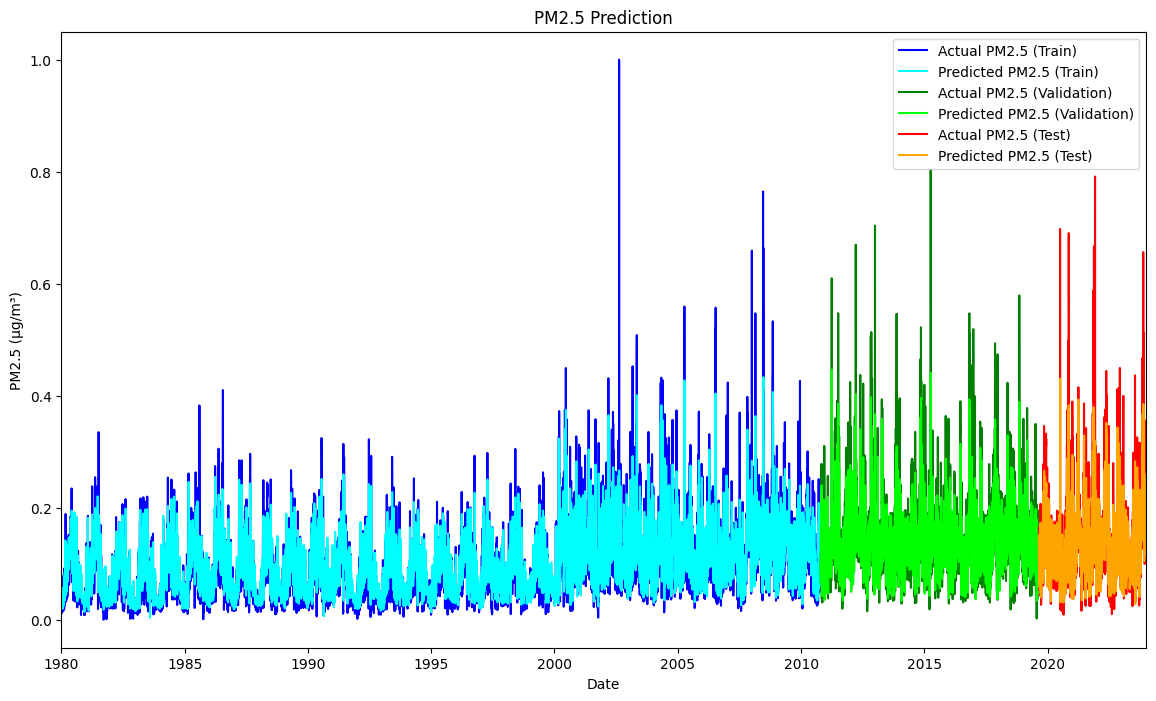

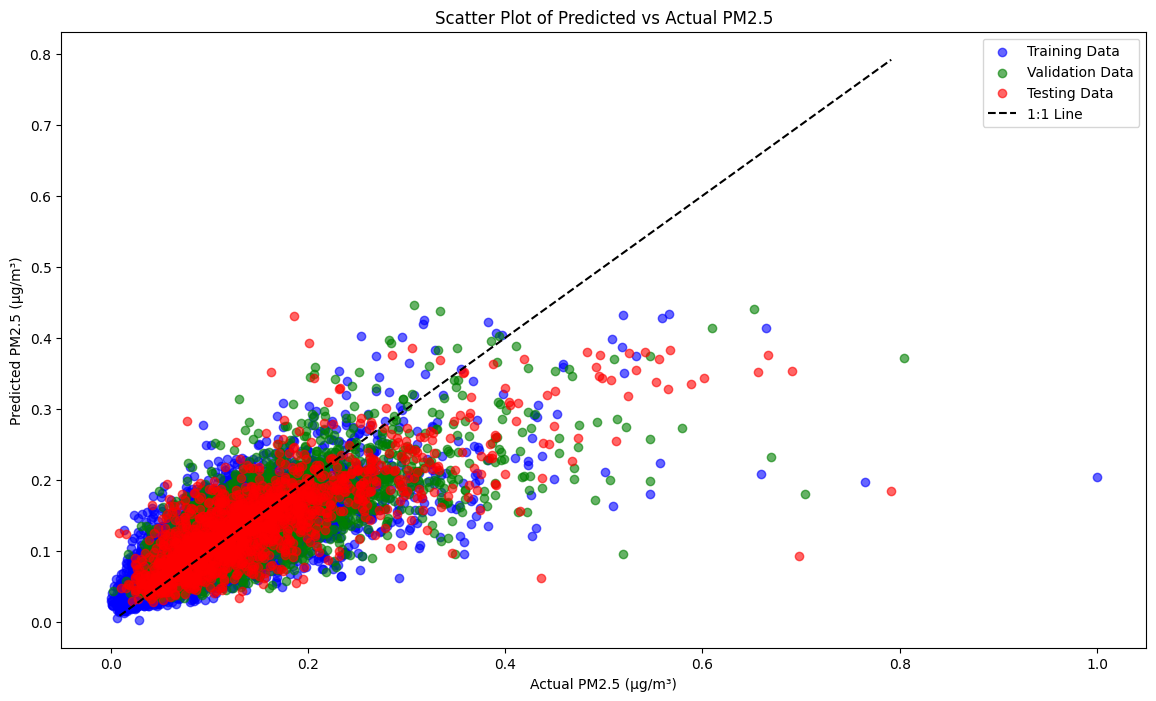

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define date range for x-axis
date_range = pd.date_range(start='1980-01-01', end='2023-12-31', freq='D')

# Ensure that lengths match
train_end_idx = len(y_train_flat)
val_end_idx = train_end_idx + len(y_val_flat)
test_end_idx = val_end_idx + len(y_test_flat)

# Adjust date range slices accordingly
dates_train = date_range[:train_end_idx]
dates_val = date_range[train_end_idx:val_end_idx]
dates_test = date_range[val_end_idx:test_end_idx]

# Plot the predictions vs actual values for the entire dataset
plt.figure(figsize=(14, 8))
plt.plot(dates_train, y_train_flat, label='Actual PM2.5 (Train)', color='blue')
plt.plot(dates_train, ensemble_train_flat, label='Predicted PM2.5 (Train)', color='cyan')
plt.plot(dates_val, y_val_flat, label='Actual PM2.5 (Validation)', color='green')
plt.plot(dates_val, ensemble_val_flat, label='Predicted PM2.5 (Validation)', color='lime')
plt.plot(dates_test, y_test_flat, label='Actual PM2.5 (Test)', color='red')
plt.plot(dates_test, ensemble_test_flat, label='Predicted PM2.5 (Test)', color='orange')
plt.title('PM2.5 Prediction')
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend()
plt.xlim(pd.to_datetime('1980-01-01'), pd.to_datetime('2023-12-31'))
plt.show()

# Scatter plot with performance metrics
plt.figure(figsize=(14, 8))
plt.scatter(y_train_flat, ensemble_train_flat, label='Training Data', color='blue', alpha=0.6)
plt.scatter(y_val_flat, ensemble_val_flat, label='Validation Data', color='green', alpha=0.6)
plt.scatter(y_test_flat, ensemble_test_flat, label='Testing Data', color='red', alpha=0.6)
plt.plot([min(y_test_flat), max(y_test_flat)], [min(y_test_flat), max(y_test_flat)], color='black', linestyle='--', label='1:1 Line')
plt.title('Scatter Plot of Predicted vs Actual PM2.5')
plt.xlabel('Actual PM2.5 (µg/m³)')
plt.ylabel('Predicted PM2.5 (µg/m³)')
plt.legend()
plt.show()

In [27]:
import tkinter as tk
from tkinter import ttk
import numpy as np
from tensorflow.keras.models import load_model

# Load the best models
best_cnn_model = load_model('best_cnn_lstm_model.keras')
best_lstm_model = load_model('best_cnn_rnn_model.keras')
best_gru_model = load_model('best_cnn_gru_model.keras')

def create_input_sequence(PM25_prev, P, P_prev, Tmin, Tmin_prev, Tmax, Tmax_prev, w, w_prev, n_steps_in=1):
    # Create a sequence with the input values
    sequence = np.array([[PM25_prev, P, P_prev, Tmin, Tmin_prev, Tmax, Tmax_prev, w, w_prev]])
    sequence = sequence.reshape((sequence.shape[0], sequence.shape[1], 1))  # Reshape for model input
    return sequence

def predict_pm25(sequence, days=5):
    predictions = []
    current_sequence = sequence.copy()  # Use copy to avoid modifying the original sequence
    
    for _ in range(days):
        # Make predictions using each model
        cnn_pred = best_cnn_model.predict(current_sequence)[0, 0]
        lstm_pred = best_lstm_model.predict(current_sequence)[0, 0]
        gru_pred = best_gru_model.predict(current_sequence)[0, 0]

        # Ensemble the predictions by averaging
        prediction = (cnn_pred + lstm_pred + gru_pred) / 3
        predictions.append(prediction)
        
        # Update the current sequence by removing the oldest value and adding the new prediction
        current_sequence = np.roll(current_sequence, shift=-1, axis=1)
        current_sequence[0, -1, 0] = prediction  # Update PM2.5 value for the next prediction
    
    return predictions

def on_predict():
    # Get input values
    try:
        PM25_prev = float(entry_pm25_prev.get())
        P = float(entry_tp.get())
        P_prev = float(entry_tp_prev.get())
        Tmax = float(entry_t2m.get())
        Tmax_prev = float(entry_tp_prev.get())
        Tmin = float(entry_t2m.get())
        Tmin_prev = float(entry_tp_prev.get())
        w = float(entry_wind.get())
        w_prev = float(entry_wind_prev.get())
    except ValueError:
        result_text.set('Please enter valid numeric values.')
        return
    
    # Create input sequence
    sequence = create_input_sequence(PM25_prev, P, P_prev, Tmin, Tmin_prev, Tmax, Tmax_prev, w, w_prev)
    
    # Predict PM2.5 for the next 5 days
    predictions = predict_pm25(sequence, days=5)
    
    # Display predictions
    result_text.set(f'Predicted PM2.5 for the next 5 days:\n{predictions}')

# Create the main window
root = tk.Tk()
root.title("PM2.5 Prediction GUI")

# Create input fields
tk.Label(root, text="Previous Day PM2.5:").grid(row=0, column=0, padx=10, pady=10)
entry_pm25_prev = ttk.Entry(root)
entry_pm25_prev.grid(row=0, column=1, padx=10, pady=10)

tk.Label(root, text="Present Day P:").grid(row=1, column=0, padx=10, pady=10)
entry_tp = ttk.Entry(root)
entry_tp.grid(row=1, column=1, padx=10, pady=10)

tk.Label(root, text="Previous Day P:").grid(row=2, column=0, padx=10, pady=10)
entry_tp_prev = ttk.Entry(root)
entry_tp_prev.grid(row=2, column=1, padx=10, pady=10)

tk.Label(root, text="Present Day Tmax:").grid(row=3, column=0, padx=10, pady=10)
entry_t2m = ttk.Entry(root)
entry_t2m.grid(row=3, column=1, padx=10, pady=10)

tk.Label(root, text="Previous Day Tmax:").grid(row=4, column=0, padx=10, pady=10)
entry_tp_prev = ttk.Entry(root)
entry_tp_prev.grid(row=4, column=1, padx=10, pady=10)

tk.Label(root, text="Present Day Tmin:").grid(row=5, column=0, padx=10, pady=10)
entry_t2m = ttk.Entry(root)
entry_t2m.grid(row=5, column=1, padx=10, pady=10)

tk.Label(root, text="Previous Day Tmin:").grid(row=6, column=0, padx=10, pady=10)
entry_tp_prev = ttk.Entry(root)
entry_tp_prev.grid(row=6, column=1, padx=10, pady=10)

tk.Label(root, text="Present Day Wind:").grid(row=7, column=0, padx=10, pady=10)
entry_wind = ttk.Entry(root)
entry_wind.grid(row=7, column=1, padx=10, pady=10)

tk.Label(root, text="Previous Day Wind:").grid(row=8, column=0, padx=10, pady=10)
entry_wind_prev = ttk.Entry(root)
entry_wind_prev.grid(row=8, column=1, padx=10, pady=10)

# Create predict button
predict_button = ttk.Button(root, text="Predict", command=on_predict)
predict_button.grid(row=9, column=0, columnspan=2, pady=10)

# Create result label
result_text = tk.StringVar()
result_label = tk.Label(root, textvariable=result_text)
result_label.grid(row=10, column=0, columnspan=2, pady=10)

# Run the GUI loop
root.mainloop()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7